In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')


### Drivers for loan defaults. just importing csv and returning a pd df

In [2]:
# creating a path to the CSV file
csv_file_path = 'loan_default.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

df

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


In [3]:
df.head(5)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [4]:
df.EmploymentType.info()

<class 'pandas.core.series.Series'>
RangeIndex: 255347 entries, 0 to 255346
Series name: EmploymentType
Non-Null Count   Dtype 
--------------   ----- 
255347 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB


In [5]:
df.isnull().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [6]:
df.columns

Index(['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore',
       'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
       'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner',
       'Default'],
      dtype='object')

In [7]:
# Create a dictionary mapping old column names to new column names
# Replace the keys with your existing column names and the values with the new names
def clean_data(df):
    """
    With this function we are changing the column names by mapping and replacing the old columns 
    with the new columns names.Setting Loan ID to index and then changing Yes and No to 1's and 0's
    
    """
    
    
    
    column_mapping = {
    'LoanID': 'loan_id',
    'Age': 'age',
    'Income': 'income',
    'LoanAmount': 'loan_amount',
    'CreditScore': 'credit_score',
    'MonthsEmployed': 'months_employed',
    'NumCreditLines': 'no_credit_lines',
    'InterestRate': 'interest_rate',
    'LoanTerm': 'loan_term',
    'DTIRatio': 'debt_income_ratio',
    'Education': 'education',
    'EmploymentType': 'employment_type',
    'MaritalStatus' :'marital_status',
    'HasMortgage' :'mortgage',
    'HasDependents' :'dependents',
    'LoanPurpose' :'loan_purpose',
    'HasCoSigner' :'cosigner',
    'Default' : 'defaulted'}
    # Rename columns using the mapping
    df.rename(columns=column_mapping, inplace=True)
    # Set 'loan_id' as the index
    df.set_index('loan_id', inplace=True)
    # just changing yes and no's to ones and zero's
    df['defaulted'] = df['defaulted'].replace({1: 'yes', 0: 'no'})
    df['mortgage'] = df['mortgage'].replace({'Yes': 1, 'No': 0})
    df['dependents'] = df['dependents'].replace({'Yes': 1, 'No': 0})
    df['cosigner'] = df['cosigner'].replace({'Yes': 1, 'No': 0})
    df['default'] = df['defaulted'].replace({'yes': 1, 'no': 0})
    return df


In [8]:
df = clean_data(df)
df

,age,income,loan_amount,credit_score,months_employed,no_credit_lines,interest_rate,loan_term,debt_income_ratio,education,employment_type,marital_status,mortgage,dependents,loan_purpose,cosigner,defaulted,default
loan_id,,,,,,,,,,,,,,,,,,
I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,1,1,Other,1,no,0
HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,0,0,Other,1,no,0
C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,1,1,Auto,0,yes,1
V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,0,0,Business,0,no,0
EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,0,1,Auto,0,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,0,0,Other,0,no,0
98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,0,0,Home,0,yes,1
XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,1,1,Auto,1,no,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255347 entries, I38PQUQS96 to ZTH91CGL0B
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                255347 non-null  int64  
 1   income             255347 non-null  int64  
 2   loan_amount        255347 non-null  int64  
 3   credit_score       255347 non-null  int64  
 4   months_employed    255347 non-null  int64  
 5   no_credit_lines    255347 non-null  int64  
 6   interest_rate      255347 non-null  float64
 7   loan_term          255347 non-null  int64  
 8   debt_income_ratio  255347 non-null  float64
 9   education          255347 non-null  object 
 10  employment_type    255347 non-null  object 
 11  marital_status     255347 non-null  object 
 12  mortgage           255347 non-null  int64  
 13  dependents         255347 non-null  int64  
 14  loan_purpose       255347 non-null  object 
 15  cosigner           255347 non-null  int64  

### noticed that there was 29653 people who have defaulted. Why?


In [10]:
count_ones = (df['defaulted'] == 'yes').sum()
count_ones

29653

In [11]:
# created new column with this function splitting my credit rating into low average and high

def cred_rating(row):
    if 300 <= row['credit_score'] <=  575:
        return 'low'
    elif 576 <= row['credit_score'] <= 700:
        return 'average'
    elif 701 <= row['credit_score'] <= 850:
        return 'high'

df['credit_rating'] = df.apply(cred_rating, axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255347 entries, I38PQUQS96 to ZTH91CGL0B
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                255347 non-null  int64  
 1   income             255347 non-null  int64  
 2   loan_amount        255347 non-null  int64  
 3   credit_score       255347 non-null  int64  
 4   months_employed    255347 non-null  int64  
 5   no_credit_lines    255347 non-null  int64  
 6   interest_rate      255347 non-null  float64
 7   loan_term          255347 non-null  int64  
 8   debt_income_ratio  255347 non-null  float64
 9   education          255347 non-null  object 
 10  employment_type    255347 non-null  object 
 11  marital_status     255347 non-null  object 
 12  mortgage           255347 non-null  int64  
 13  dependents         255347 non-null  int64  
 14  loan_purpose       255347 non-null  object 
 15  cosigner           255347 non-null  int64  

In [13]:
df.credit_rating.value_counts()

low        128383
high        68946
average     58018
Name: credit_rating, dtype: int64

### noticed there is alot of people in the low column for credit rating 

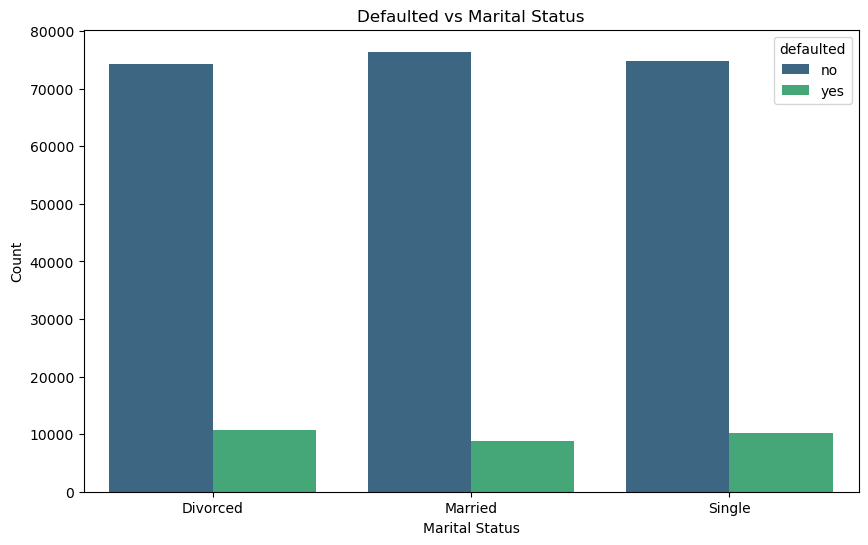

In [14]:
# Create a count plot for education and defaulted
plt.figure(figsize=(10, 6))
sns.countplot(x='marital_status', hue='defaulted', data=df, palette='viridis')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Defaulted vs Marital Status')
plt.show()

### Divorced has a higher loan default which it is not shocking which is not too noticable 

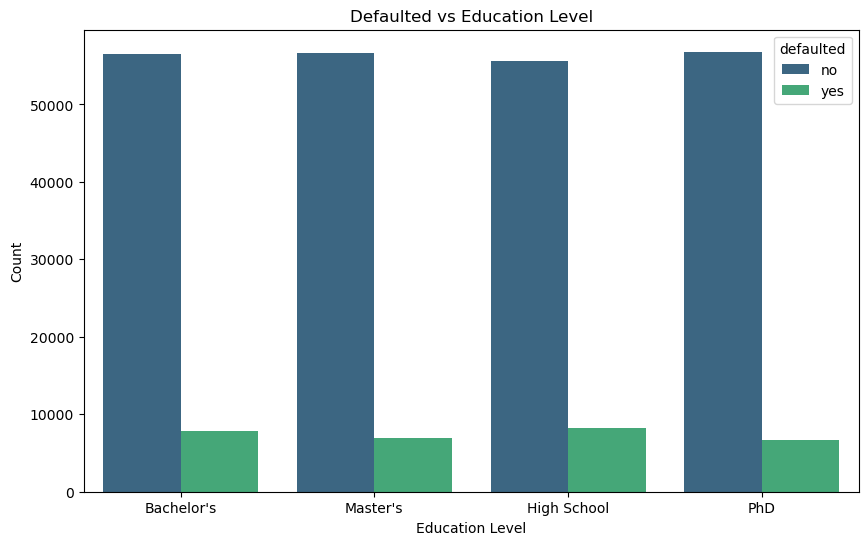

In [15]:
# Create a count plot for education and defaulted
plt.figure(figsize=(10, 6))
sns.countplot(x='education', hue='defaulted', data=df, palette='viridis')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Defaulted vs Education Level')
plt.show()

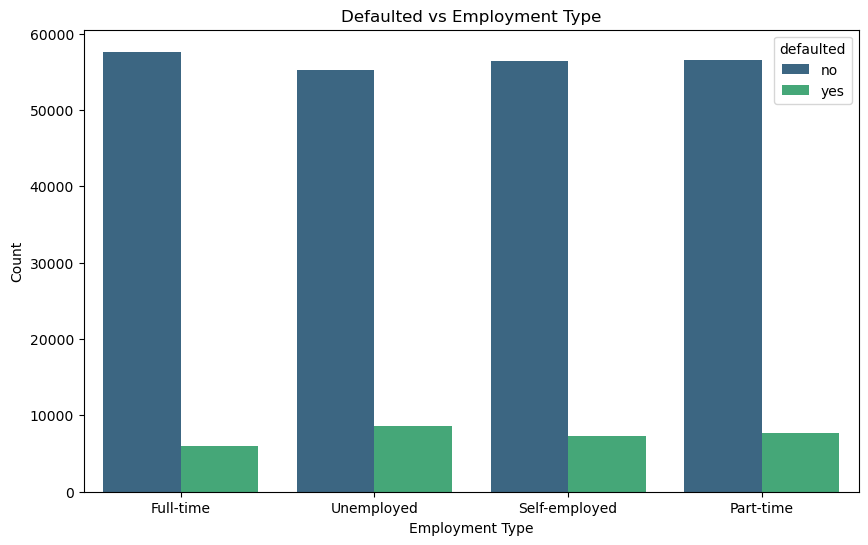

In [16]:
# Create a count plot for education and defaulted
plt.figure(figsize=(10, 6))
sns.countplot(x='employment_type', hue='defaulted', data=df, palette='viridis')
plt.xlabel('Employment Type')
plt.ylabel('Count')
plt.title('Defaulted vs Employment Type')
plt.show()

### unemployed of course has a higher default rate due to being unemployed more than likely

In [17]:
# Split data
def split_data(df):
    '''
    split continuouse data into train, validate, test;target variable being qualit

    returns train, validate, test
    '''

    train_val, test = train_test_split(df,
                                   train_size=0.8,
                                   random_state=123,
                                   stratify = df['defaulted'])
    train, validate = train_test_split(train_val,
                                   train_size=0.75,
                                   random_state=123,
                                   stratify=train_val['defaulted'])
    
    print(f'Train: {len(train)/len(df)}')
    print(f'Validate: {len(validate)/len(df)}')
    print(f'Test: {len(test)/len(df)}')
    

    return train, validate, test

In [18]:
train, validate, test = split_data(df)
train.head()

Train: 0.5999953005126357
Validate: 0.20000234974368214
Test: 0.20000234974368214


,age,income,loan_amount,credit_score,months_employed,no_credit_lines,interest_rate,loan_term,debt_income_ratio,education,employment_type,marital_status,mortgage,dependents,loan_purpose,cosigner,defaulted,default,credit_rating
loan_id,,,,,,,,,,,,,,,,,,,
2FEE66HVO3,57,32880,38552,474,108,2,8.60,24,0.62,High School,Full-time,Divorced,0,1,Business,1,no,0,low
FXEAZ6F4KJ,20,57608,228885,522,2,4,13.86,12,0.65,Bachelor's,Full-time,Divorced,1,0,Other,0,no,0,low
KMM2TU8JGI,18,137506,216972,584,93,4,3.69,12,0.67,Bachelor's,Part-time,Single,1,0,Auto,1,no,0,average
YMBWR05BG6,20,66320,34880,423,38,4,19.02,60,0.27,High School,Self-employed,Married,0,0,Home,1,yes,1,low
H2J918A441,31,39220,152376,391,105,3,5.04,60,0.75,Master's,Self-employed,Single,0,0,Education,1,no,0,low


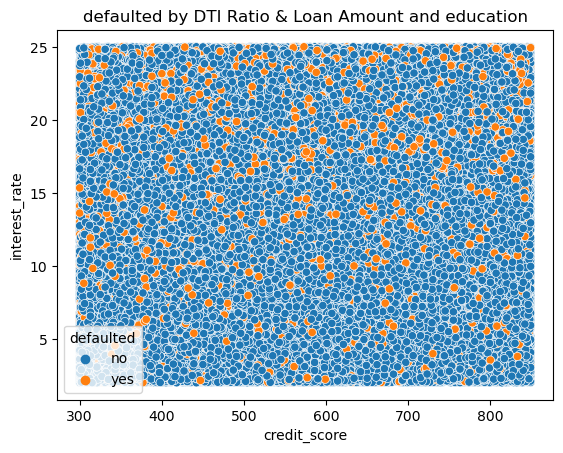

In [19]:
# Scatterplot but it is a mess and not easy to look at
sns.scatterplot(x='credit_score', y='interest_rate', data=train, hue='defaulted')

plt.title('defaulted by DTI Ratio & Loan Amount and education')
plt.show()


### I am going to seperate my train data in catagorical and numerical data

In [20]:
def cat_and_num_col(data, cat_col, target_col):
    """
    Separate categorical and numerical columns in a DataFrame.

    Parameters:
    - data: DataFrame
    - categorical_columns: list of str, names of categorical columns
    - target_column: str, name of the target column (e.g., 'defaulted')

    Returns:
    - categorical_data: DataFrame, contains only categorical columns
    - numerical_data: DataFrame, contains only numerical columns and the target column
    """
    # Separate categorical columns
    cat_data = data[cat_col].copy()

    # Separate numerical columns and include the target column
    num_data = data.drop(cat_col, axis=1).copy()

    return cat_data, num_data
# created variable that inclued cat_cols and target_cols
cat_col = ['education', 'marital_status', 'employment_type', 'loan_purpose', 'credit_rating']
target_col = 'defaulted'






In [21]:
cat_col, num_col = cat_and_num_col(train, cat_col, target_col)

In [22]:
cat_col

,education,marital_status,employment_type,loan_purpose,credit_rating
loan_id,,,,,
2FEE66HVO3,High School,Divorced,Full-time,Business,low
FXEAZ6F4KJ,Bachelor's,Divorced,Full-time,Other,low
KMM2TU8JGI,Bachelor's,Single,Part-time,Auto,average
YMBWR05BG6,High School,Married,Self-employed,Home,low
H2J918A441,Master's,Single,Self-employed,Education,low
...,...,...,...,...,...
2S807PV9RL,PhD,Married,Self-employed,Business,low
HJQJSJXTFV,Bachelor's,Married,Part-time,Business,low
0BT6XL67MC,Master's,Married,Part-time,Other,low


In [23]:
num_col

,age,income,loan_amount,credit_score,months_employed,no_credit_lines,interest_rate,loan_term,debt_income_ratio,mortgage,dependents,cosigner,defaulted,default
loan_id,,,,,,,,,,,,,,
2FEE66HVO3,57,32880,38552,474,108,2,8.60,24,0.62,0,1,1,no,0
FXEAZ6F4KJ,20,57608,228885,522,2,4,13.86,12,0.65,1,0,0,no,0
KMM2TU8JGI,18,137506,216972,584,93,4,3.69,12,0.67,1,0,1,no,0
YMBWR05BG6,20,66320,34880,423,38,4,19.02,60,0.27,0,0,1,yes,1
H2J918A441,31,39220,152376,391,105,3,5.04,60,0.75,0,0,1,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2S807PV9RL,55,57658,23121,385,21,1,24.09,60,0.71,1,1,0,no,0
HJQJSJXTFV,18,70228,126058,431,95,4,6.42,60,0.80,1,0,1,no,0
0BT6XL67MC,67,112537,78814,373,21,2,23.78,36,0.49,0,0,1,no,0


### maybe unnecessary but we got some more information on how many people actually defaulted

In [24]:
rejected_sum = (df['defaulted'] == 'yes' ).sum()

print(f"Sum of 'defaulted' loan status: {rejected_sum}")

Sum of 'defaulted' loan status: 29653


### so we have 29,653 of our loans are defaulted out of 255347  loans

In [25]:
def defaulted_overall(df):
    '''plots overall loan responses
    of the data frame and returns 
    a bargraph'''
    # create a figure
    fig = plt.figure(figsize=(12, 6)) 
    ax = fig.add_subplot(111)

    # proportion of observation of each class
    prop_response = df['defaulted'].value_counts(normalize=True)

    # create a bar plot showing the percentage of churn
    prop_response.plot(kind='bar', 
                    ax=ax)


    # set title and labels
    ax.set_title('Percentage not defaulted vs defaulted',
                fontsize=18)
    ax.set_xlabel('loan_status',
                fontsize=14)
    ax.set_ylabel('Percentage of data',
                fontsize=14)
    ax.tick_params(rotation='auto')

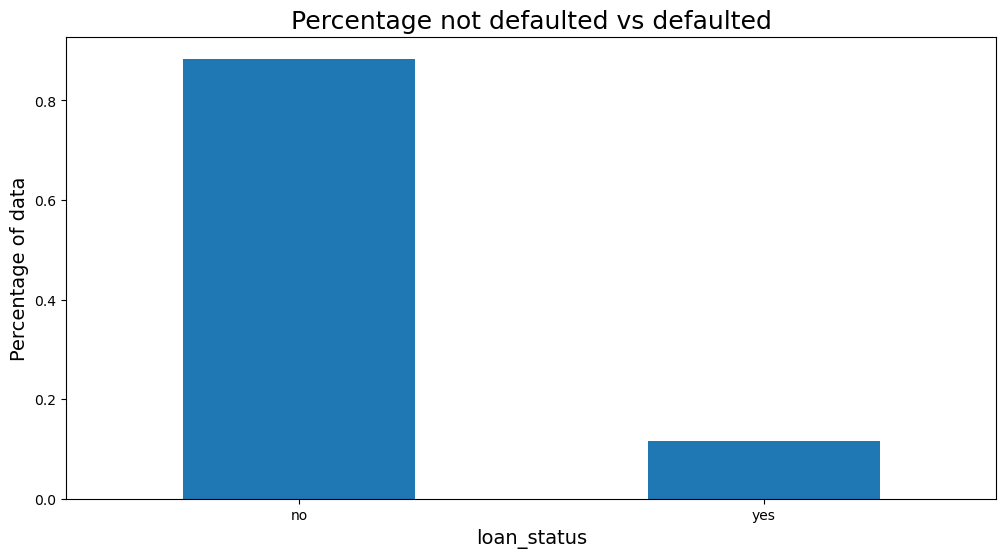

In [26]:
defaulted_overall(train)

### shows that loans are around 89 percent are not defaulted and over 10 percent are defaulted

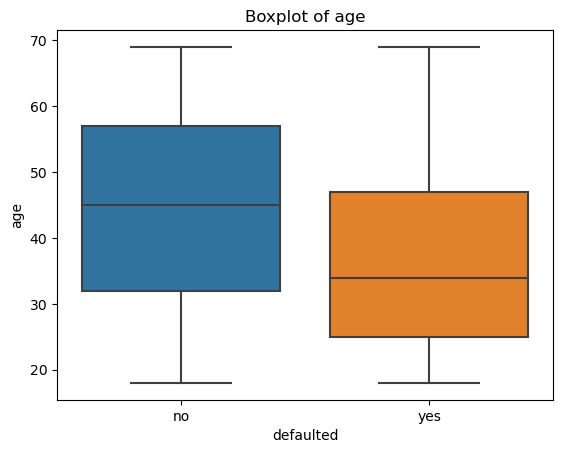

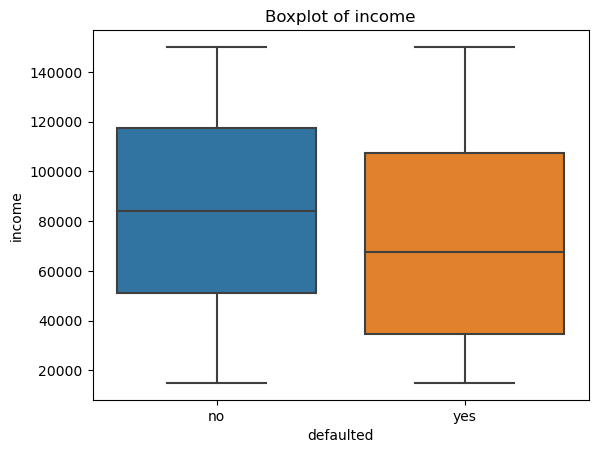

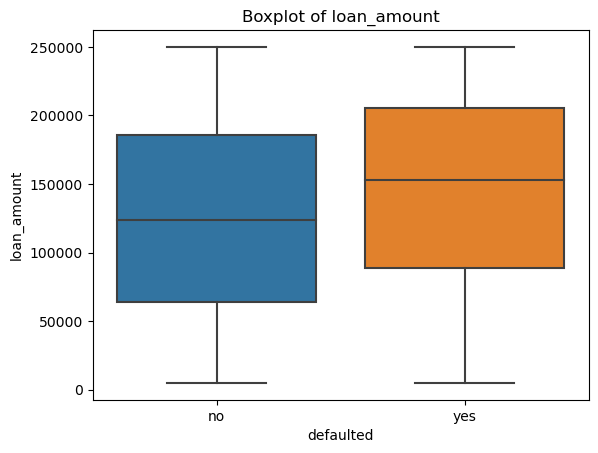

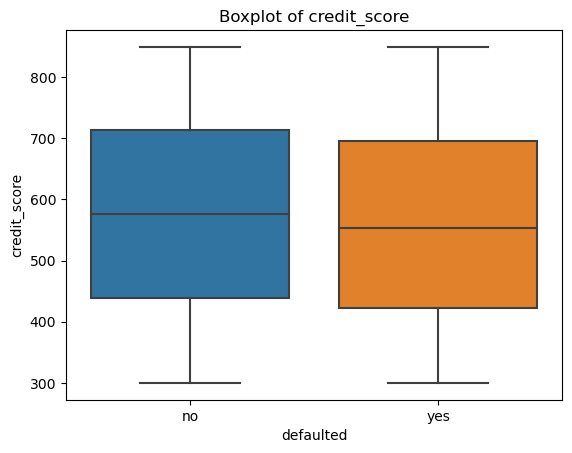

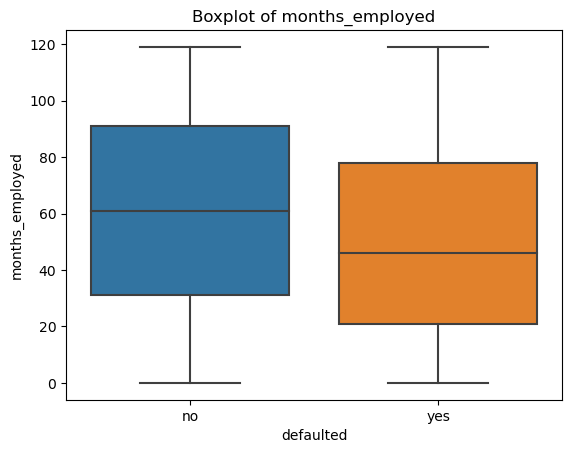

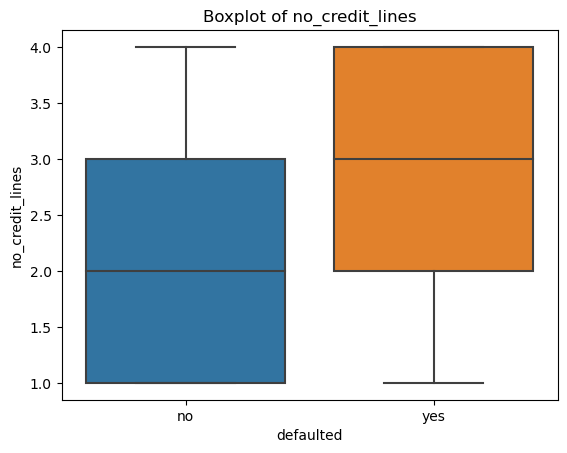

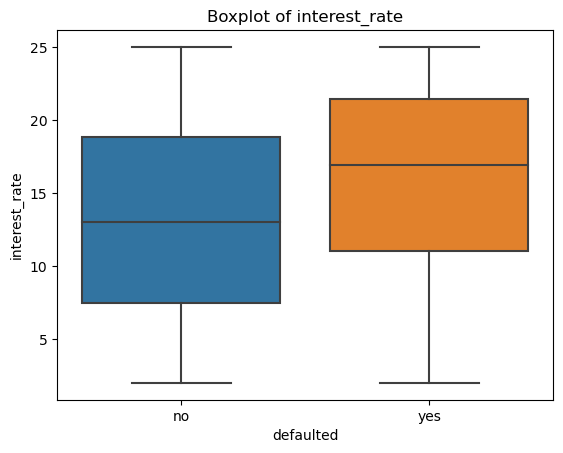

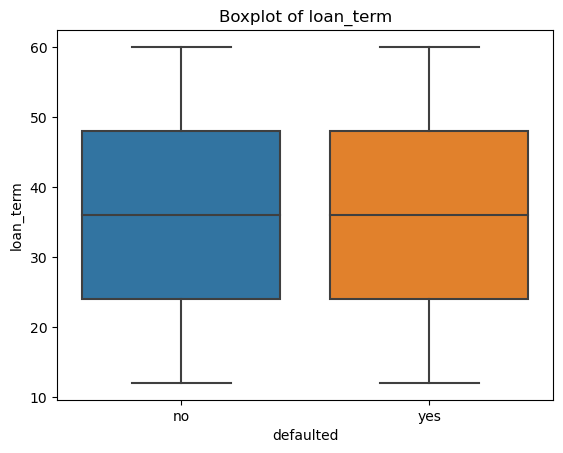

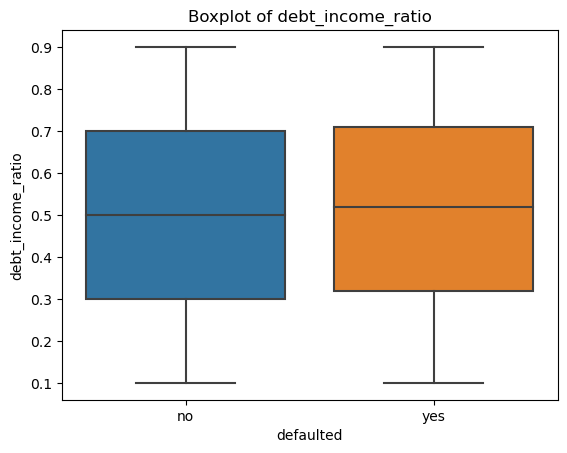

TypeError: Neither the `x` nor `y` variable appears to be numeric.

In [27]:
for col in train:
    sns.boxplot(data=train, x='defaulted', y= col)
    plt.title(f'Boxplot of {col}')
    plt.show()

In [28]:
# trying to see some more info on credit score and defualting 

average_credit_score_defaulted = df[df['default'] == 1]['credit_score'].describe()

print("Average Credit Score for Defaulted Loans:", average_credit_score_defaulted)


Average Credit Score for Defaulted Loans: count    29653.000000
mean       559.286143
std        158.521855
min        300.000000
25%        421.000000
50%        553.000000
75%        693.000000
max        849.000000
Name: credit_score, dtype: float64


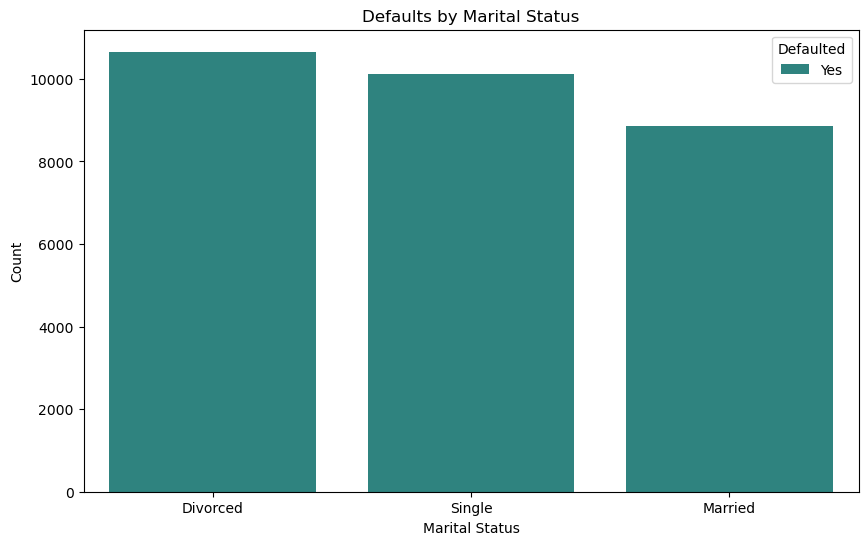

In [29]:
# Created a contingency table for marital status and defaulted
contingency_table = pd.crosstab(df['marital_status'], df['defaulted'])

# Create a bar chart that shows just yes for which marital status had the most defaults
plt.figure(figsize=(10, 6))
sns.countplot(x='marital_status', hue='defaulted', data=df[df['defaulted'] == 'yes'], palette='viridis')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Defaults by Marital Status')
plt.legend(title='Defaulted', labels=['Yes'])
plt.show()




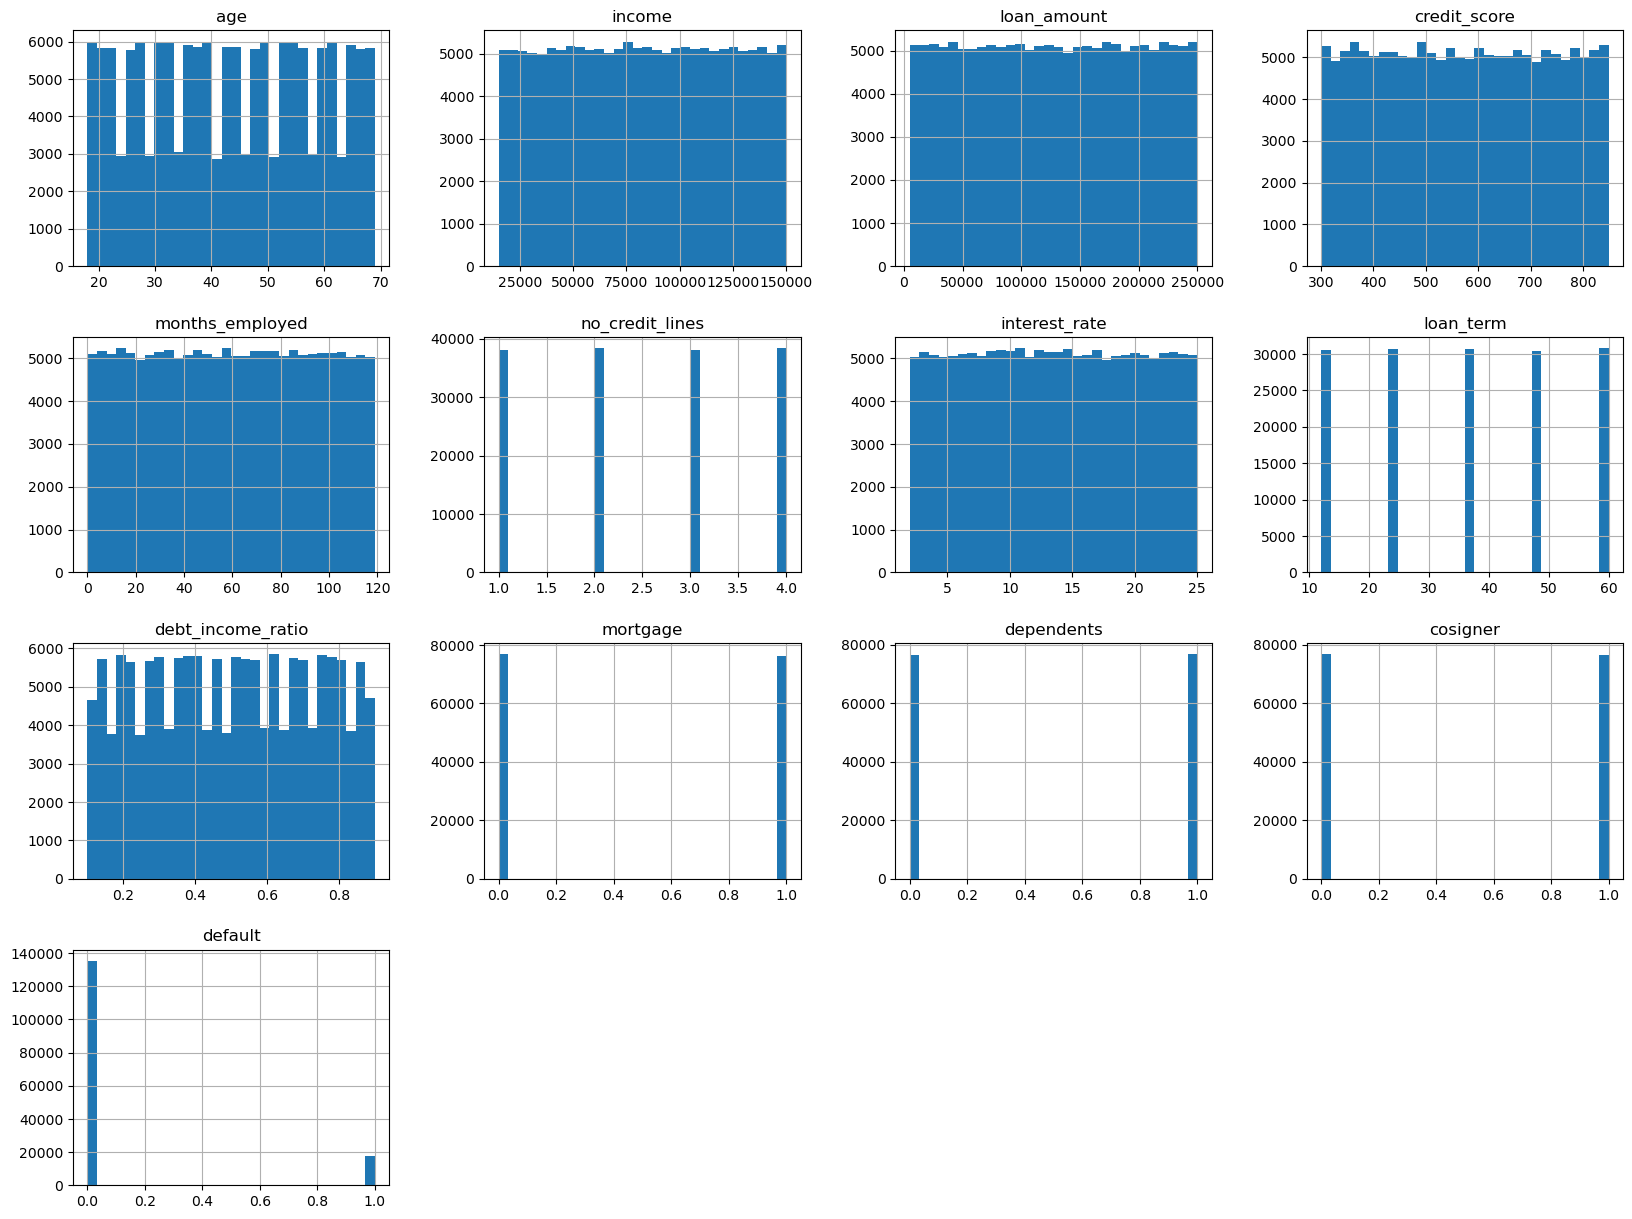

In [30]:
train.hist(bins=30, figsize=(20,15))
plt.show()

### Possible stats testing i could do: 

- Chi-Square Test: This test is used to determine if there is a significant association between two categorical variables1. For example, you might want to know if the loan default status is associated with the borrower’s employment status.

- T-Test: A t-test can help you compare the means of two groups and determine if they are significantly different from each other1. For instance, you might want to compare the average income of defaulters vs non-defaulters.

- Mann-Whitney U Test: This is a non-parametric test that can be used to compare two independent

In [31]:
train.default

loan_id
2FEE66HVO3    0
FXEAZ6F4KJ    0
KMM2TU8JGI    0
YMBWR05BG6    1
H2J918A441    0
             ..
2S807PV9RL    0
HJQJSJXTFV    0
0BT6XL67MC    0
F89RZDETDJ    0
GH271BTM8X    0
Name: default, Length: 153207, dtype: int64

In [32]:
alpha = 0.05

In [33]:
from scipy.stats import chi2_contingency

In [34]:
### $H_o$: There is no association between each cat col and defaulting.

### $H_a$: There is an association between each cat col and defaulting.

In [35]:
# Perform chi-squared tests for each cat column
for col in cat_col :
    contingency_table = pd.crosstab(train[col], train['default'])
    chi2, p, _, _ = chi2_contingency(contingency_table)

    print(f"Chi-squared test for {col}:")
    print(f"  Chi-squared statistic: {chi2}")
    print(f"  P-value: {p}")
    print("")
     # Check if p-value is less than alpha
    if p < alpha:
        print(f'We reject the null hypothesis.')
    else:
        print(f'We fail to reject the null hypothesis.')
    
    print("")  

Chi-squared test for education:
  Chi-squared statistic: 143.51508094931307
  P-value: 6.59902967862175e-31

We reject the null hypothesis.

Chi-squared test for marital_status:
  Chi-squared statistic: 138.01764566262156
  P-value: 1.0711469159809627e-30

We reject the null hypothesis.

Chi-squared test for employment_type:
  Chi-squared statistic: 336.1155698667674
  P-value: 1.513220167248282e-72

We reject the null hypothesis.

Chi-squared test for loan_purpose:
  Chi-squared statistic: 89.91749339652236
  P-value: 1.3709845876579425e-18

We reject the null hypothesis.

Chi-squared test for credit_rating:
  Chi-squared statistic: 124.63129730075818
  P-value: 8.64286351673073e-28

We reject the null hypothesis.



### $H_o$: There is no association between age and defaulting.

### $H_a$: There is an association between age and defaulting.

In [36]:
from scipy.stats import ttest_ind
#  with a numerical variable  and binary target default
group_0 = train[train.defaulted == 'no'].age
group_1 = train[train.defaulted == 'yes'].age

In [37]:
# Perform t-testP
t_statistic, p_value = ttest_ind(group_0, group_1)
print(f't_statistic:',t_statistic)
print(f'p_value:',p_value)

t_statistic: 65.78369214154512
p_value: 0.0


In [38]:
if p_value/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t_statistic < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

We reject the null hypothesis.


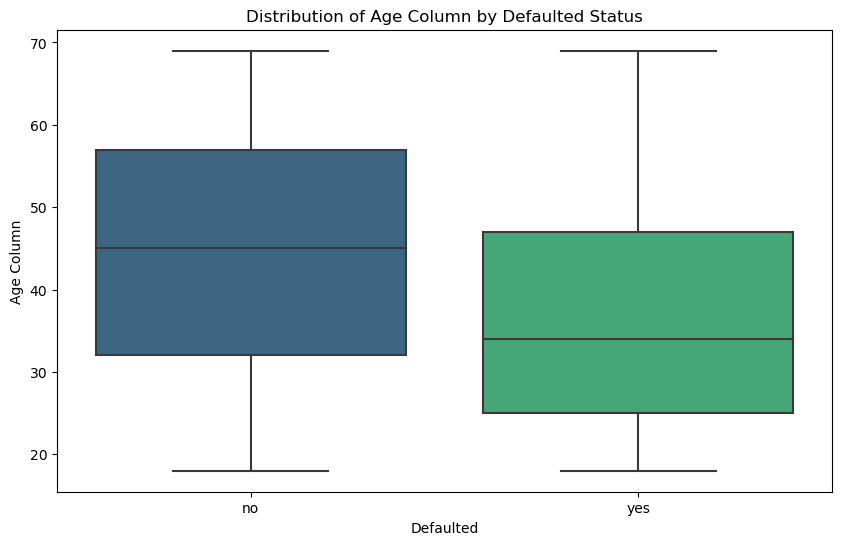

In [39]:
# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='defaulted', y='age', data=train, palette='viridis')
# Add significance indicator for p-value

plt.xlabel('Defaulted')
plt.ylabel('Age Column')
plt.title('Distribution of Age Column by Defaulted Status')
plt.show()

### $H_o$: There is no association between no_of_credit_lines and defaulting.

### $H_a$: There is an association between no_of_credit_lines and defaulting.

In [40]:
# Example with a numerical variable and binary target defaulted
group0 = train[train.default == 0].no_credit_lines
group1 = train[train.default == 1].no_credit_lines

# Perform t-test
t_statistic, p_value = ttest_ind(group0, group1)

In [41]:
print(t_statistic)
print(p_value)

-12.286617706653468
1.1098665374991854e-34


In [42]:
if p_value/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t_statistic < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

We fail to reject null hypothesis.


### look into bar chart possible

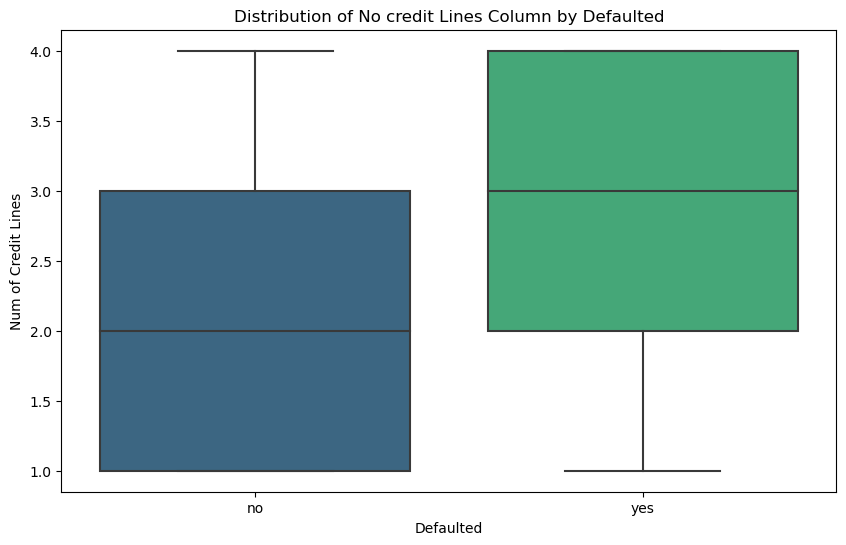

In [43]:
# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='defaulted', y='no_credit_lines', data=train, palette='viridis')


plt.xlabel('Defaulted')
plt.ylabel('Num of Credit Lines')
plt.title('Distribution of No credit Lines Column by Defaulted')
plt.show()

### $H_o$: There is no association between intrest_rate and defaulting.

### $H_a$: There is an association between intrest_rate and defaulting.

In [44]:
# Example with a numerical variable and binary target defaulted
intrest_rate_0 = train[train.default == 0].interest_rate
intrest_rate_1 = train[train.default == 1].interest_rate

# Perform t-test
t_statistic, p_value = ttest_ind(intrest_rate_0, intrest_rate_1)

In [45]:
print(t_statistic)
print(p_value)

-52.17109940445979
0.0


In [46]:
if p_value/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t_statistic < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

We fail to reject null hypothesis.


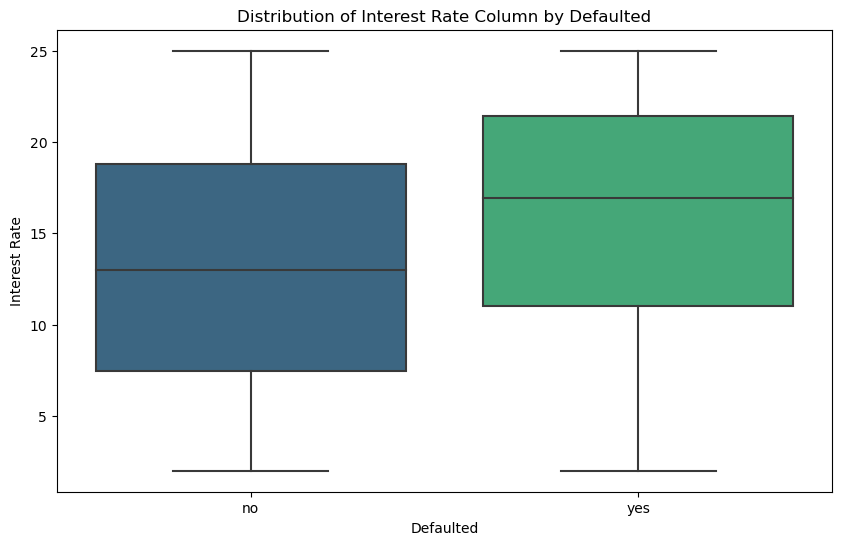

In [47]:
# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='defaulted', y='interest_rate', data=train, palette='viridis')


plt.xlabel('Defaulted')
plt.ylabel('Interest Rate')
plt.title('Distribution of Interest Rate Column by Defaulted')
plt.show()

### $H_o$: There is no association between intrest_rate and defaulting.
​
### $H_a$: There is an association between intrest_rate and defaulting.

In [48]:
# Example with a numerical variable and binary target defaulted
intrest_rate_0 = train[train.default == 0].interest_rate
intrest_rate_1 = train[train.default == 1].interest_rate

# Perform t-test
t_statistic, p_value = ttest_ind(intrest_rate_0, intrest_rate_1)


In [49]:
# Example with a numerical variable and binary target defaulted
income_0 = train[train.default == 0].income
income_1 = train[train.default == 1].income

# Perform t-test
t_statistic, p_value = ttest_ind(income_0, income_1)

In [50]:
print(t_statistic)
print(p_value)

37.68455529485235
2.35268135542907e-309


In [51]:
if p_value/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t_statistic < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

We reject the null hypothesis.


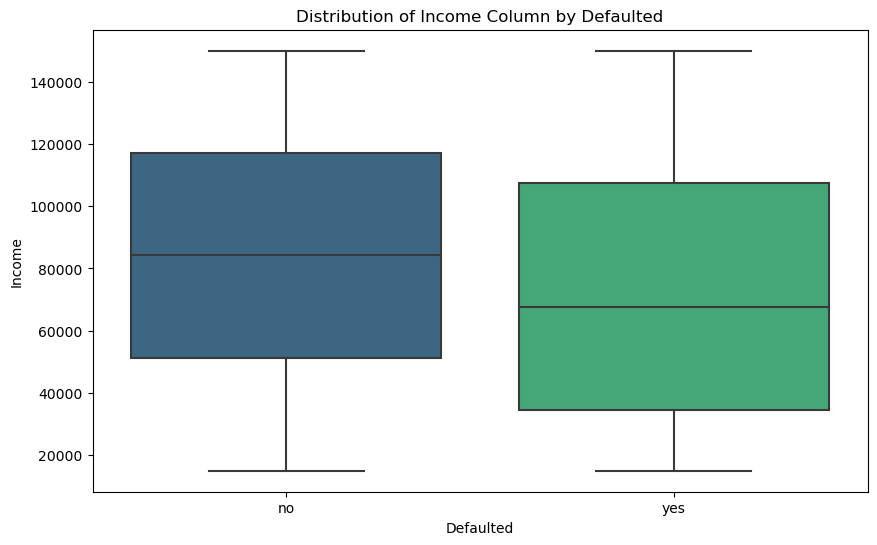

In [52]:
# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='defaulted', y='income', data=train, palette='viridis')


plt.xlabel('Defaulted')
plt.ylabel('Income')
plt.title('Distribution of Income Column by Defaulted')
plt.show()

### $H_o$: There is no association between cosigner and defaulting.

### $H_a$: There is an association between cosigner and defaulting.

In [53]:
# Example with a numerical variable and binary target defaulted
cosigner_0 = train[train.default == 0].cosigner
cosigner_1 = train[train.default == 1].cosigner

# Perform t-test
t_statistic, p_value = ttest_ind(cosigner_0, cosigner_1)

In [54]:
print(t_statistic)
print(p_value)

16.004138390594175
1.331610074172519e-57


In [55]:
if p_value/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t_statistic < 0:
    print("We fail to reject null hypothesis.")
else:
    print("We reject the null hypothesis.")

We reject the null hypothesis.


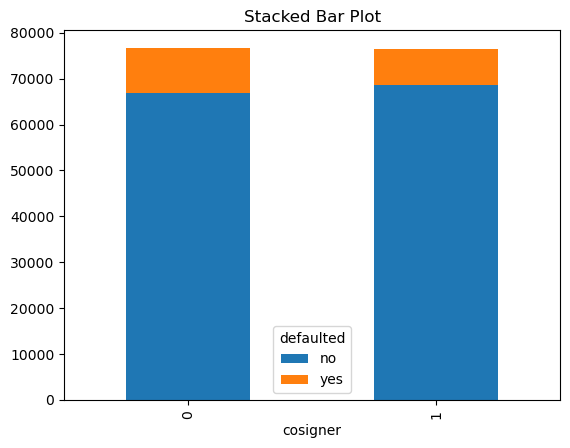

In [56]:
contingency_table = pd.crosstab(train['cosigner'], train['defaulted'])
contingency_table.plot(kind='bar', stacked=True, title='Stacked Bar Plot')
plt.show()


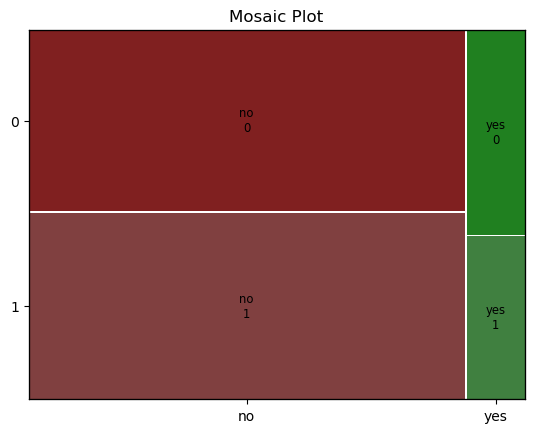

In [57]:
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt

mosaic(train, ['defaulted', 'cosigner'], title='Mosaic Plot')
plt.show()


### Possible Models I want to use

- Random Forest Classifier: This model is often used for predicting loan default as it can handle a large amount of data with high dimensionality. It’s an ensemble learning method that operates by constructing multiple decision trees and outputs the class that is the mode of the classes output by individual trees.

- Gradient Boosting (XGBoost): XGBoost is another popular model used in loan default prediction3. It’s an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It produces an ensemble of weak prediction models, typically decision trees.

- Logistic Regression: Logistic regression is a statistical model used in binary classification problems like loan default prediction. It’s a simple and efficient model to start with, especially when the relationship between the target and the features is not very complex and you don’t have a lot of computational power.


- Decision Trees: Decision trees are also used in predicting loan default. They are simple to understand and interpret, and can handle both categorical and numerical data.



In [58]:
train

,age,income,loan_amount,credit_score,months_employed,no_credit_lines,interest_rate,loan_term,debt_income_ratio,education,employment_type,marital_status,mortgage,dependents,loan_purpose,cosigner,defaulted,default,credit_rating
loan_id,,,,,,,,,,,,,,,,,,,
2FEE66HVO3,57,32880,38552,474,108,2,8.60,24,0.62,High School,Full-time,Divorced,0,1,Business,1,no,0,low
FXEAZ6F4KJ,20,57608,228885,522,2,4,13.86,12,0.65,Bachelor's,Full-time,Divorced,1,0,Other,0,no,0,low
KMM2TU8JGI,18,137506,216972,584,93,4,3.69,12,0.67,Bachelor's,Part-time,Single,1,0,Auto,1,no,0,average
YMBWR05BG6,20,66320,34880,423,38,4,19.02,60,0.27,High School,Self-employed,Married,0,0,Home,1,yes,1,low
H2J918A441,31,39220,152376,391,105,3,5.04,60,0.75,Master's,Self-employed,Single,0,0,Education,1,no,0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2S807PV9RL,55,57658,23121,385,21,1,24.09,60,0.71,PhD,Self-employed,Married,1,1,Business,0,no,0,low
HJQJSJXTFV,18,70228,126058,431,95,4,6.42,60,0.80,Bachelor's,Part-time,Married,1,0,Business,1,no,0,low
0BT6XL67MC,67,112537,78814,373,21,2,23.78,36,0.49,Master's,Part-time,Married,0,0,Other,1,no,0,low


In [59]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['default','defaulted','education','employment_type','marital_status','loan_purpose','credit_rating'])
y_train = train.default

X_validate = validate.drop(columns=['default','defaulted','education','employment_type','marital_status','loan_purpose','credit_rating'])
y_validate = validate.default

X_test = test.drop(columns=['default','defaulted','education','employment_type','marital_status','loan_purpose','credit_rating'])
y_test = test.default


In [60]:
X_train

,age,income,loan_amount,credit_score,months_employed,no_credit_lines,interest_rate,loan_term,debt_income_ratio,mortgage,dependents,cosigner
loan_id,,,,,,,,,,,,
2FEE66HVO3,57,32880,38552,474,108,2,8.60,24,0.62,0,1,1
FXEAZ6F4KJ,20,57608,228885,522,2,4,13.86,12,0.65,1,0,0
KMM2TU8JGI,18,137506,216972,584,93,4,3.69,12,0.67,1,0,1
YMBWR05BG6,20,66320,34880,423,38,4,19.02,60,0.27,0,0,1
H2J918A441,31,39220,152376,391,105,3,5.04,60,0.75,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2S807PV9RL,55,57658,23121,385,21,1,24.09,60,0.71,1,1,0
HJQJSJXTFV,18,70228,126058,431,95,4,6.42,60,0.80,1,0,1
0BT6XL67MC,67,112537,78814,373,21,2,23.78,36,0.49,0,0,1


Text(0.5, 1.0, 'Scaled')

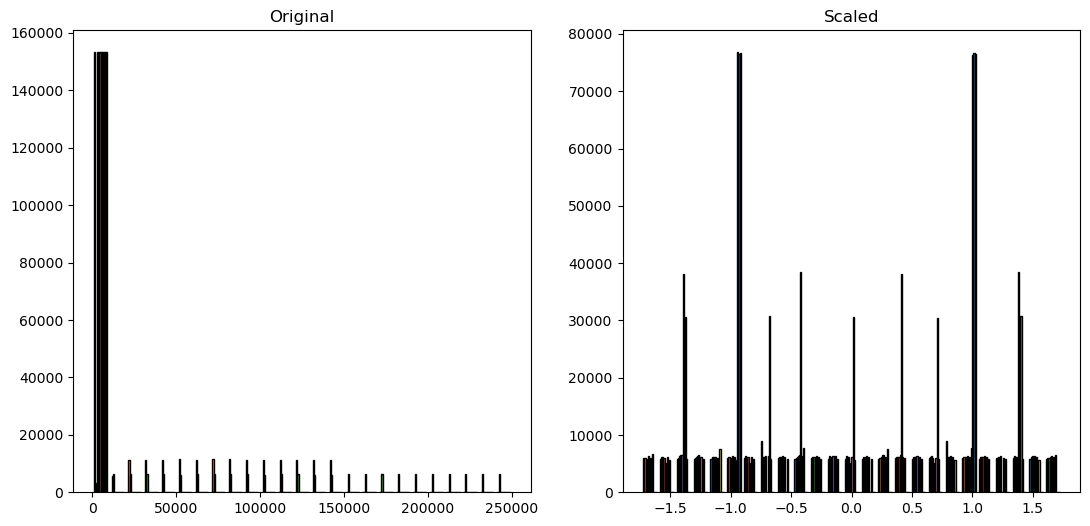

In [61]:
scaler = sklearn.preprocessing.StandardScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')


In [62]:
# The most frequenly observed outcome will be our baseline
train.default.value_counts(normalize=True)

0    0.883876
1    0.116124
Name: default, dtype: float64

In [63]:
baseline_accuracy = (train.default == 0).mean()
round(baseline_accuracy, 2)

0.88

In [64]:
clf = DecisionTreeClassifier(max_depth=4, random_state=123)
# model.fit(X, y)

clf = clf.fit(X_train, y_train)

In [65]:
# make prediction on train obeservations
y_pred = clf.predict(X_train)
y_pred



array([0, 0, 0, ..., 0, 0, 0])

In [66]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba


array([[0.96311309, 0.03688691],
       [0.84980555, 0.15019445],
       [0.91374428, 0.08625572],
       ...,
       [0.86483669, 0.13516331],
       [0.73400922, 0.26599078],
       [0.86483669, 0.13516331]])

In [67]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.88


In [68]:
# confusion matrix

confusion_matrix(y_train, y_pred)


array([[134787,    629],
       [ 17069,    722]])

In [69]:
y_train.value_counts()


0    135416
1     17791
Name: default, dtype: int64

In [70]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,0,1
0,134787,629
1,17069,722


In [71]:
print(classification_report(y_train, y_pred))
print(f"Baseline is:",baseline_accuracy)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94    135416
           1       0.53      0.04      0.08     17791

    accuracy                           0.88    153207
   macro avg       0.71      0.52      0.51    153207
weighted avg       0.85      0.88      0.84    153207

Baseline is: 0.8838760631041662


## Decision Tree Meets baseline

# Random Forest Modeling time

In [72]:
rf = RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [73]:
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [74]:
# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = rf.predict(X_train)

In [75]:
# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 3 depth")
print(f"Baseline is:",baseline_accuracy)
pd.DataFrame(report)

Tree of 3 depth
Baseline is: 0.8838760631041662


,0,1,accuracy,macro avg,weighted avg
precision,0.883876,0.0,0.883876,0.441938,0.781237
recall,1.000000,0.0,0.883876,0.500000,0.883876
f1-score,0.938359,0.0,0.883876,0.469180,0.829393
support,135416.000000,17791.0,0.883876,153207.000000,153207.000000


In [76]:
# sklearn confusion matrix
pd.DataFrame(confusion_matrix(y_predictions, y_train))

,0,1
0,135416,17791
1,0,0


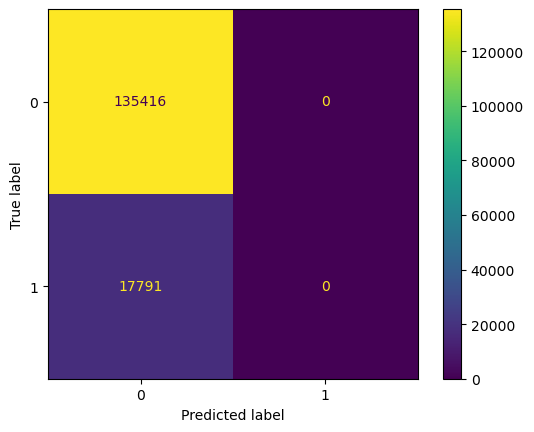

In [77]:
ConfusionMatrixDisplay.from_estimator(rf, X_train, y_train);

In [78]:
TN, FP, FN, TP = confusion_matrix(y_train,y_predictions).ravel()
ALL = TP + TN + FP + FN

TP, TN, FP, FN

(0, 135416, 0, 17791)

In [79]:
accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.8838760631041662
True Positive Rate: 0.0
False Positive Rate: 0.0
True Negative Rate: 1.0
False Negative Rate: 1.0
Precision: nan
Recall: 0.0
F1 Score: nan
Support (0): 17791
Support (1): 135416


In [80]:
# Let's 
for i in range(2, 8):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                       0        1  accuracy      macro avg   weighted avg
precision       0.883876      0.0  0.883876       0.441938       0.781237
recall          1.000000      0.0  0.883876       0.500000       0.883876
f1-score        0.938359      0.0  0.883876       0.469180       0.829393
support    135416.000000  17791.0  0.883876  153207.000000  153207.000000

Tree with max depth of 3
                       0        1  accuracy      macro avg   weighted avg
precision       0.883876      0.0  0.883876       0.441938       0.781237
recall          1.000000      0.0  0.883876       0.500000       0.883876
f1-score        0.938359      0.0  0.883876       0.469180       0.829393
support    135416.000000  17791.0  0.883876  153207.000000  153207.000000

Tree with max depth of 4
                       0        1  accuracy      macro avg   weighted avg
precision       0.883876      0.0  0.883876       0.441938       0.781237
recall          1.000000      0.0  

# Random Forest meets baseline as well 

# KNN model now

In [81]:
baseline_prediction = y_train.mode()
baseline_prediction

0    0
Name: default, dtype: int64

In [82]:
pd.Series((baseline_prediction[0]), range(len(y_train)))

0         0
1         0
2         0
3         0
4         0
         ..
153202    0
153203    0
153204    0
153205    0
153206    0
Length: 153207, dtype: int64

In [83]:
def establish_baseline(y_train):
    #  establish the value we will predict for all observations
    baseline_prediction = y_train.mode()

    # create a series of predictions with that value, 
    # the same length as our training set
    y_train_pred = pd.Series((baseline_prediction[0]), range(len(y_train)))

    # compute accuracy of baseline
    cm = confusion_matrix(y_train, y_train_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp+tn)/(tn+fp+fn+tp)
    return accuracy

In [84]:
establish_baseline(y_train)


0.8838760631041662

In [85]:
# MAKE the thing
knn = KNeighborsClassifier()

# FIT the thing
knn.fit(X_train, y_train)

# USE the thing
y_train_pred = knn.predict(X_train)

In [86]:
#get the accuracy score of train set
train_score = knn.score(X_train, y_train)
train_score

0.889848375074246

In [87]:
#confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
pd.DataFrame(cm, index=['Actual_0', 'Actual_1'], 
             columns=['Pred_0', 'Pred_1'])

,Pred_0,Pred_1
Actual_0,134269,1147
Actual_1,15729,2062


In [88]:
#classification report
print(classification_report(y_train, y_train_pred))
print(f'baseline is:',establish_baseline(y_train))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94    135416
           1       0.64      0.12      0.20     17791

    accuracy                           0.89    153207
   macro avg       0.77      0.55      0.57    153207
weighted avg       0.87      0.89      0.85    153207

baseline is: 0.8838760631041662


In [89]:
#classification report as a df
pd.DataFrame(classification_report(y_train, 
                                   y_train_pred, 
                                   output_dict=True)).T



,precision,recall,f1-score,support
0,0.895139,0.991530,0.940872,135416.000000
1,0.642568,0.115901,0.196381,17791.000000
accuracy,0.889848,0.889848,0.889848,0.889848
macro avg,0.768853,0.553716,0.568626,153207.000000
weighted avg,0.865809,0.889848,0.854419,153207.000000


# KNN performed slightly above baseline

# Time for logistic Regression

In [90]:
# Create the logistic regression
logit = LogisticRegression(random_state=123)

# specify the features we're using
features = ["age", "no_credit_lines", "interest_rate"]

# Fit a model using only these specified features
logit.fit(X_train[features], y_train)

# Since we .fit on a subset, we .predict on that same subset of features
y_pred = logit.predict(X_train[features])

print("Baseline is", round(baseline_accuracy, 2))
print("Logistic Regression using age, lines of credit, and Interest Rate features")
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train[features], y_train)))

Baseline is 0.88
Logistic Regression using age, lines of credit, and Interest Rate features
Accuracy of Logistic Regression classifier on training set: 0.88


### adding more features

In [91]:
# Create the logistic regression
logit = LogisticRegression(random_state=123, class_weight='balanced')

# specify the features we're using
features = ["age", "no_credit_lines", "interest_rate"]

# Fit a model using only these specified features
logit.fit(X_train[features], y_train)

# Since we .fit on a subset, we .predict on that same subset of features
y_pred = logit.predict(X_train[features])

print("Baseline is", round(baseline_accuracy, 2))
print("Logistic Regression using age, lines of credit, and Interest Rate features")
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train[features], y_train)))

Baseline is 0.88
Logistic Regression using age, lines of credit, and Interest Rate features
Accuracy of Logistic Regression classifier on training set: 0.63


In [92]:
# Convert the dataset into an optimized data structure called DMatrix that XGBoost supports
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify the parameters
params = {
    'objective':'binary:logistic',
    'max_depth': 4,
    'alpha': 10,
    'learning_rate': 1.0,
    'n_estimators':100
}

# Train the model
model = xgb.train(params, dtrain)

# Make predictions
preds = model.predict(dtest)

# It gives feature importance 

In [93]:
# Get feature importance
importance = model.get_score(importance_type='weight')

# Print feature importance
for feature, score in importance.items():
    print(f'Feature: {feature}, Score: {score}')

Feature: age, Score: 17.0
Feature: income, Score: 23.0
Feature: loan_amount, Score: 25.0
Feature: credit_score, Score: 11.0
Feature: months_employed, Score: 15.0
Feature: no_credit_lines, Score: 3.0
Feature: interest_rate, Score: 31.0
Feature: debt_income_ratio, Score: 9.0
Feature: mortgage, Score: 3.0
Feature: dependents, Score: 4.0
Feature: cosigner, Score: 6.0


In [94]:
# Convert the dataset to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for the xgboost
param = {'max_depth': 4, 'eta': 0.3, 'objective': 'reg:squarederror'}

# Train the model
num_round = 20
bst = xgb.train(param, dtrain, num_round)


In [95]:
from sklearn.metrics import mean_squared_error

# Make prediction
preds = bst.predict(dtest)

# Print the predictions
print("Predictions:", preds)

# Calculate the baseline prediction: mean of target variable it is its own way scaling
baseline_preds = np.full(y_test.shape, np.mean(y_train))

# Calculate RMSE for the baseline predictions
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
print("Baseline RMSE:", baseline_rmse)


Predictions: [0.02392063 0.20396562 0.01361351 ... 0.02057705 0.14708586 0.0679303 ]
Baseline RMSE: 0.3203863990024923


In [109]:
import pandas as pd

# Create a dataframe with actual and predicted values
xgb_reg_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': preds,
    'Baseline_RMSE': baseline_rmse
})

# Print the baseline RMSE
print("Baseline RMSE:", baseline_rmse)


Baseline RMSE: 0.3203863990024923


In [114]:
xgb_reg_df

,Actual,Predicted,Baseline_RMSE
loan_id,,,
57E79Q4XUD,0,0.023921,0.320386
HORLIV3CDB,0,0.203966,0.320386
QRMBNKXQKY,0,0.013614,0.320386
K19PHXETPR,0,0.043504,0.320386
7CO1OLJP79,0,0.102896,0.320386
...,...,...,...
SONGV0L6MV,0,0.034328,0.320386
HO7ZNL86DX,1,0.034958,0.320386
OZHOJDKR5D,0,0.020577,0.320386


In [113]:
xgb_reg_df.Predicted.mean()

0.116539255

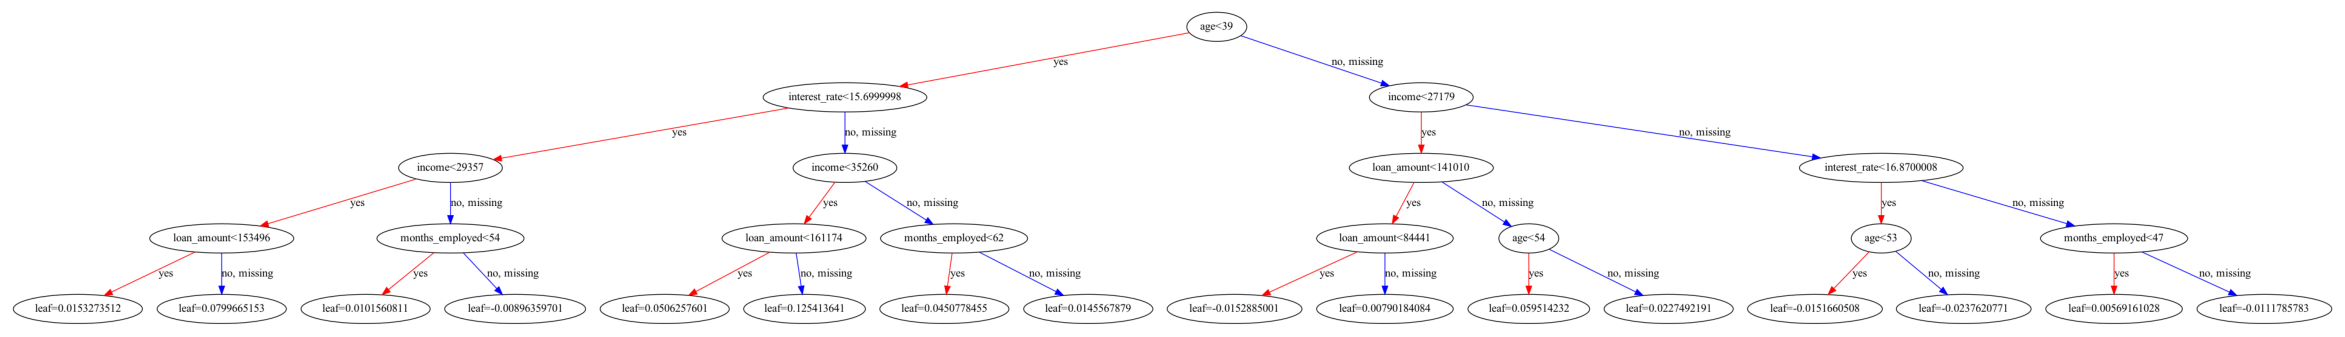

In [108]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor, plot_tree

# Assuming 'bst' is your trained model
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(bst, num_trees=0, ax=ax)

plt.savefig('tree.pdf')
